In [1]:
!pip install tables==3.7.0

     |████████████████████████████████| 5.9 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 384 kB 56.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import sys
sys.path.insert(1, 'CMAPSS')
import eval_utils
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import gridspec
params = {'legend.fontsize': 20,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)

2024-05-01 08:56:04.796442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import importlib
importlib.reload(eval_utils)

<module 'eval_utils' from '/baja/CMAPSS_GITHUB/eval_utils.py'>

# Load Data

In [4]:
# Load data partial window
PATH_IN = 'Data/N-CMAPSS'

# Load training data
X_windows = np.load(PATH_IN + '/X_windows.npy')
U_windows = np.load(PATH_IN + '/U_windows.npy')
C_windows = np.load(PATH_IN + '/C_windows.npy')
W_windows = np.load(PATH_IN + '/W_windows.npy')
Y_windows = np.load(PATH_IN + '/Y_windows.npy')

# Load testing data
X_windows_test = np.load(PATH_IN + '/X_windows_test.npy')
U_windows_test = np.load(PATH_IN + '/U_windows_test.npy')
C_windows_test = np.load(PATH_IN + '/C_windows_test.npy')
W_windows_test = np.load(PATH_IN + '/W_windows_test.npy')
Y_windows_test = np.load(PATH_IN + '/Y_windows_test.npy')

print(X_windows.shape, X_windows_test.shape)

(663, 2030, 14) (438, 2030, 14)


In [5]:
# Ground Truth HI
PATH_IN = 'Data/N-CMAPSS'
SOURCE = 'N-CMAPSS_DS03'

ground_truth = pd.read_hdf(PATH_IN + "/" + SOURCE+'_cycle_test.h5', 'df')
ground_truth2 = pd.read_hdf(PATH_IN + "/" + SOURCE+'_cycle_dev.h5', 'df')

ground_truth = pd.concat([ground_truth,ground_truth2]).sort_values('unit').sort_index()


g_units = ground_truth.unit.values
g_his = ground_truth.HI.values

g_cycles = []
_, s_idx = np.unique(g_units, return_index=True)
for i in g_units[np.sort(s_idx)]:
    idx = np.ravel(g_units==i)
    g_cycles.extend(np.arange(idx.sum())+1)
g_cycles = np.array(g_cycles)

train_idx = np.ravel(np.isin(g_units,[np.unique(U_windows)]))
true_hi_train = g_his[train_idx].reshape(-1,1)
true_hi_cycles = g_cycles[train_idx]
true_hi_units = g_units[train_idx]


test_idx = np.ravel(np.isin(g_units,[np.unique(U_windows_test)]))
true_hi_test = g_his[test_idx].reshape(-1,1)
true_hi_cycles_test = g_cycles[test_idx]
true_hi_units_test = g_units[test_idx]
print(true_hi_train.shape, true_hi_test.shape)

(663, 1) (438, 1)


# Ground Truth HI evaluation

In [6]:
results = eval_utils.init_hi_result_dict()

        
results['MAPE_TR'].append('-')
results['MAE_TR'].append('-')

results['M_TR'].append(eval_utils.monotonicity(true_hi_train,true_hi_units))
results['T_TR'].append(eval_utils.trend_spearman(true_hi_train,true_hi_cycles,true_hi_units))
results['FC_TR'].append(eval_utils.failure_consistency(true_hi_train,true_hi_units))
results['MI_TR'].append(eval_utils.mutual_information(true_hi_train.reshape(-1,1),Y_windows[:,0,:].reshape(-1,1),true_hi_units))

results['MAPE_TS'].append('-')
results['MAE_TS'].append('-')
results['M_TS'].append(eval_utils.monotonicity(true_hi_test,true_hi_units_test))
results['T_TS'].append(eval_utils.trend_spearman(true_hi_test,true_hi_cycles_test,true_hi_units_test))
results['FC_TS'].append(eval_utils.failure_consistency(true_hi_test,true_hi_units_test))
results['MI_TS'].append(eval_utils.mutual_information(true_hi_test.reshape(-1,1),Y_windows_test[:,0,:].reshape(-1,1),true_hi_units_test))
results['I'].append(0)
results['TIME'].append(0)
pd.DataFrame(results)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,-,-,0.492105,0.992803,1.0,0.838808,-,-,0.504344,0.991013,1.0,0.842728,0,0


# Proposed Model

In [7]:
class C_constraint(tf.keras.layers.Layer):   # Inheritance class
    def __init__(self,alpha,**kwargs):  
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def call(self, inputdata):
        x, t = inputdata
        x_mu = tf.reduce_mean(x)
        t_mu = tf.reduce_mean(t)
        cov = tf.reduce_sum((x-x_mu)*(t-t_mu))
        std = tf.math.pow(tf.reduce_sum((x-x_mu)**2),0.5) * tf.math.pow(tf.reduce_sum((t-t_mu)**2),0.5)
        loss = cov/std
        loss = tf.reduce_mean(loss)
        
        self.add_loss(self.alpha*loss)
        self.add_metric(loss, aggregation='mean', name='l1')
        return x
    
class NG_constraint(tf.keras.layers.Layer):   # Inheritance class
    def __init__(self,alpha,**kwargs):  
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def call(self, inputdata):
        x,t = inputdata
        x_diff = x[1:]-x[:-1]
        t_diff = t[1:]-t[:-1]
        grad = x_diff/t_diff
        loss = tf.reduce_sum(tf.math.maximum(tf.constant(0.0),grad))
        self.add_loss(self.alpha*loss)
        self.add_metric(loss, aggregation='mean', name='Grad')

        return x
    
class F_constraint(tf.keras.layers.Layer):   # Inheritance class
    def __init__(self,alpha,**kwargs):  
        super().__init__(**kwargs)
        self.alpha = alpha
        
        self.A = 0.012
        self.B = 4.95
        self.C = 0.89
        self.BETA = 6.7
        self.P = 0.5
        
    def call(self, inputdata):
        x, t = inputdata
        HI = self.C - ((t * (-np.log(1 - self.P))**(-1/self.BETA))*self.A)**self.B
        mask = tf.math.less(HI,0)
        HI = tf.where(mask,0.0,HI)
        loss = tf.reduce_mean(tf.abs(x-HI))
        
        self.add_loss(self.alpha*loss)
        self.add_metric(loss, aggregation='mean', name='l1')
        return x
    
def H_index_Proposal_CNN(latent_dims,Window_size = 100,z_size=1,cnn_dim = 85,stride = 1,alpha = 1,constraint = 'C'):
    
    x_dim = 14
    w_dim = 4
    
    inpX = tf.keras.layers.Input(shape=(Window_size,x_dim),name = 'InpX')
    inputT = tf.keras.layers.Input(shape=(1,),name = 'inpT')
    inpW = tf.keras.layers.Input(shape=(Window_size,w_dim),name = 'inpW')
    x = inpX
    w_in = inpW
    
    for i in latent_dims:
        x=tf.keras.layers.Conv1D(i,cnn_dim,stride,activation='relu',padding = 'same')(x)

    x = tf.keras.layers.Flatten(name = 'flatten')(x)
    x = tf.keras.layers.Dense(z_size,name="Z")(x) #activity_regularizer=regularizers.l1(10e-5)
    
    if constraint == 'C':
        x = C_constraint(alpha, name='constrained')([x, inputT])
    elif constraint == 'NG':
        x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x), name='Z_after')(x)
        x = NG_constraint(alpha, name='constrained')([x, inputT])
    elif constraint == 'F':
        x = F_constraint(alpha, name='constrained')([x, inputT])
    else:
        raise ValueError("Invalid constraint type. Must be 'C', 'NG', or 'F'") 
    
    x = tf.keras.layers.RepeatVector(Window_size,name='repeat')(x)
    
    x = tf.keras.layers.Concatenate(axis  =-1)([x,w_in])
    for i in reversed(latent_dims):
        x = tf.keras.layers.Conv1D(i,cnn_dim,strides=1,activation='relu',padding = 'same')(x)
    x=tf.keras.layers.Dense(x_dim,name='X')(x)   
       
    model = tf.keras.models.Model([inpX,inputT,inpW],x)
    return model

In [19]:
constraint = 'C'
layers=  [128,64,32,16]
Window_size = X_windows.shape[1]
model = H_index_Proposal_CNN(layers,Window_size,constraint = constraint)

In [20]:
result,z_train,z_test = eval_utils.train_and_evaluate_proposed_model(X_windows, W_windows, C_windows, U_windows,Y_windows,true_hi_train,X_windows_test, W_windows_test, C_windows_test, U_windows_test,Y_windows_test,true_hi_test,
                                             model,runs = 1, epochs = 50, batch_size=20,learning_rate = 0.0001)

RUN#:  0
Epoch 1/50
34/34 [==============================] - 7s 80ms/step - loss: 0.1505 - mae: 0.0843 - l1: 0.0861
Epoch 2/50
34/34 [==============================] - 3s 79ms/step - loss: 0.0572 - mae: 0.0412 - l1: 0.0372
Epoch 3/50
34/34 [==============================] - 3s 79ms/step - loss: 0.0225 - mae: 0.0274 - l1: 0.0167
Epoch 4/50
34/34 [==============================] - 3s 80ms/step - loss: -0.0382 - mae: 0.0272 - l1: -0.0422
Epoch 5/50
34/34 [==============================] - 3s 87ms/step - loss: -0.0791 - mae: 0.0194 - l1: -0.0745
Epoch 6/50
34/34 [==============================] - 3s 80ms/step - loss: -0.0668 - mae: 0.0207 - l1: -0.0638
Epoch 7/50
34/34 [==============================] - 3s 81ms/step - loss: -0.0936 - mae: 0.0219 - l1: -0.0910
Epoch 8/50
34/34 [==============================] - 3s 79ms/step - loss: -0.0778 - mae: 0.0197 - l1: -0.0734
Epoch 9/50
34/34 [==============================] - 3s 80ms/step - loss: -0.1130 - mae: 0.0163 - l1: -0.1044
Epoch 10/50
34/3

In [21]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,0.028535,11.407257,0.358611,0.979938,0.908843,0.815183,0.030331,10.632612,0.371021,0.981955,0.8964,0.815858,150.364882,0


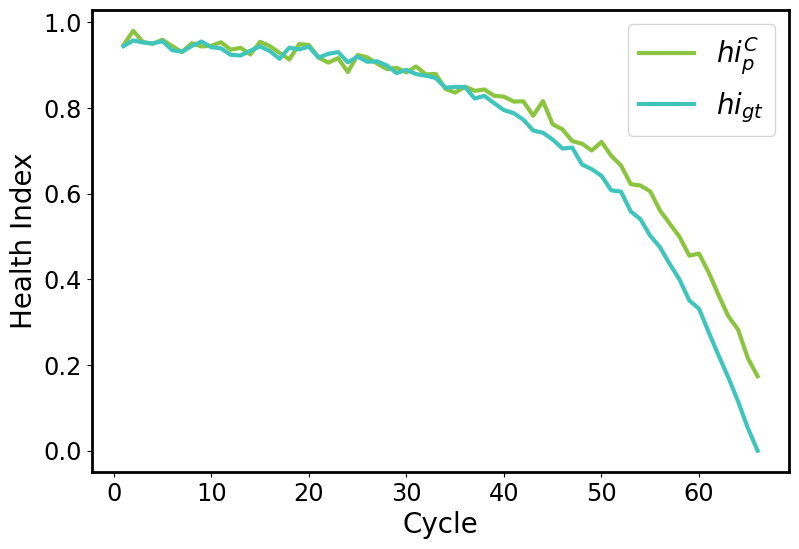

In [22]:
cycles_smooth, units_smooth = eval_utils.smooth_cycle_units(C_windows_test,U_windows_test)
u = 10
run_id = 0
idx = np.ravel(units_smooth==u)
plt.plot(cycles_smooth[idx],z_test[run_id][idx],'#8BC53F',label = r'$hi_{p}^C$',linewidth = 3)
idx2 = np.ravel(g_units==u)
plt.plot(g_cycles[idx2],g_his[idx2],'#3FC5BC',label = r'$hi_{gt}$' ,linewidth = 3)
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('Health Index')
plt.show()